# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
source = pd.read_excel('geo_comment.xlsx')
source.head()

,x,y,comment_class,multiplier,comment
0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...
1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...
2,37.603298,55.742108,-1,1,Внести в Проект правил землепользования и заст...
3,37.558526,55.728758,-1,1,Учитывая социальную значимость проекта строите...
4,37.566431,55.731794,-1,1,Учитывая социальную значимость проекта строите...


In [11]:
source.describe()

,x,y,comment_class,multiplier
count,70382.000000,70382.000000,70382.000000,70382.000000
mean,37.588417,55.786013,-0.663835,1.545935
std,0.138217,0.066225,0.747885,16.986786
min,37.148813,55.496939,-1.000000,1.000000
25%,37.445608,55.743558,-1.000000,1.000000
50%,37.570887,55.792331,-1.000000,1.000000
75%,37.702822,55.848665,-1.000000,1.000000
max,37.931228,55.994174,1.000000,1500.000000


#### Проверим комментарии на дубликаты.

In [5]:
source.comment.duplicated().value_counts()

True     63047
False     7335
Name: comment, dtype: int64

#### Данные очень сильно задублированы, 7335 уникальных записей определенно не окончательная цифра, т.к. в данных могу содержаться не эквивалентные дубликаты (с небольшими опечатками и т.д.). Очистку нужно проводить основываясь на дистанции между текстами в комментариях.
#### В текущем задании грубо очистим данные от дубликатов, удалив лишь 100% дубликаты. Координаты и класс комментария возьмем по максимуму, колличество посчитаем суммой.

In [17]:
source_max = source.groupby(by=['comment'],as_index=False).max()
source_sum = source.groupby(by=['comment'],as_index=False).sum()

In [18]:
source_max.head()

,comment,x,y,comment_class,multiplier
0,"""В 2010 году жителями была остановлена попытка...",37.545276,55.794436,-1,409
1,"""О проекте Правил землепользования и заст...",37.639033,55.740781,-1,1
2,"""ООО """"Ласточка"""" является собственником 2 зем...",37.529322,55.762145,1,1
3,"""ООО «БУТАКОВСКИЙ», рассмотрев материалы предс...",37.647387,55.883792,-1,1
4,"""Проект планировки территории, ограниченной Ни...",37.470051,55.669625,-1,1


In [19]:
source_sum.head()

,comment,x,y,comment_class,multiplier
0,"""В 2010 году жителями была остановлена попытка...",37.545276,55.794436,-1,409
1,"""О проекте Правил землепользования и заст...",150.526075,222.921570,-4,4
2,"""ООО """"Ласточка"""" является собственником 2 зем...",37.529322,55.762145,1,1
3,"""ООО «БУТАКОВСКИЙ», рассмотрев материалы предс...",75.089482,111.715857,-2,2
4,"""Проект планировки территории, ограниченной Ни...",74.927984,111.337346,-2,2


In [23]:
source_cleaned = source_max.filter(['comment', 'x', 'y', 'comment_class'], axis=1)
source_cleaned['multiplier'] = source_sum['multiplier']

In [24]:
source_cleaned.head()

,comment,x,y,comment_class,multiplier
0,"""В 2010 году жителями была остановлена попытка...",37.545276,55.794436,-1,409
1,"""О проекте Правил землепользования и заст...",37.639033,55.740781,-1,4
2,"""ООО """"Ласточка"""" является собственником 2 зем...",37.529322,55.762145,1,1
3,"""ООО «БУТАКОВСКИЙ», рассмотрев материалы предс...",37.647387,55.883792,-1,2
4,"""Проект планировки территории, ограниченной Ни...",37.470051,55.669625,-1,2


In [40]:
source_cleaned.describe()

,x,y,comment_class,multiplier
count,7.335000e+03,7.335000e+03,7335.000000,7335.000000
mean,5.060165e-15,-1.041282e-13,-0.021132,14.833810
std,1.000068e+00,1.000068e+00,0.999845,153.410564
min,-3.321637e+00,-3.769673e+00,-1.000000,1.000000
25%,-8.966486e-01,-7.050360e-01,-1.000000,1.000000
50%,-4.517540e-02,1.583863e-01,-1.000000,1.000000
75%,7.624678e-01,8.635122e-01,1.000000,2.000000
max,3.199241e+00,2.797997e+00,1.000000,5910.000000


#### Проведем нормализацию координат.

In [27]:
scaler = StandardScaler()

In [38]:
source_cleaned[['x', 'y']] = scaler.fit_transform(source_cleaned[['x', 'y']])

In [41]:
source_cleaned.describe()

,x,y,comment_class,multiplier
count,7.335000e+03,7.335000e+03,7335.000000,7335.000000
mean,5.060165e-15,-1.041282e-13,-0.021132,14.833810
std,1.000068e+00,1.000068e+00,0.999845,153.410564
min,-3.321637e+00,-3.769673e+00,-1.000000,1.000000
25%,-8.966486e-01,-7.050360e-01,-1.000000,1.000000
50%,-4.517540e-02,1.583863e-01,-1.000000,1.000000
75%,7.624678e-01,8.635122e-01,1.000000,2.000000
max,3.199241e+00,2.797997e+00,1.000000,5910.000000


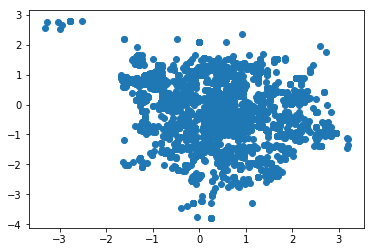

In [39]:
plt.scatter(source_cleaned.x, source_cleaned.y)

### Визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
### Подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)

In [42]:
from sklearn.cluster import KMeans

In [43]:
k_inertia = []
ks = range(1,11)

for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans_clusters = kmeans.fit_predict(source_cleaned[['x', 'y']])
    k_inertia.append(kmeans.inertia_)

In [44]:
k_inertia

[14670.0,
 7074.0164230728205,
 4436.0653035553187,
 3509.6926460690961,
 2640.8330781249106,
 2131.3637700382164,
 1702.7187883069716,
 1518.7465698856156,
 1414.2733758624088,
 1250.414207318669]

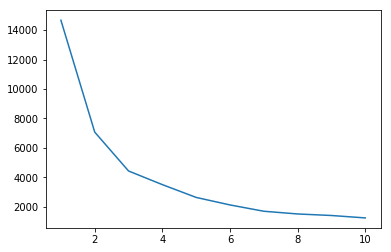

In [45]:
plt.plot(ks, k_inertia)

In [46]:
diff = np.diff(k_inertia)

In [47]:
diff

array([-7595.98357693, -2637.95111952,  -926.37265749,  -868.85956794,
        -509.46930809,  -428.64498173,  -183.97221842,  -104.47319402,
        -163.85916854])

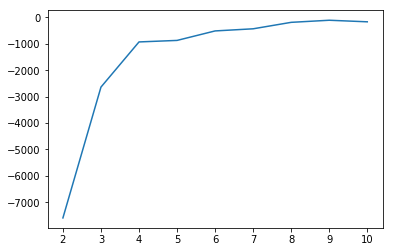

In [48]:
plt.plot(ks[1:], diff)

In [49]:
diff_r = diff[1:] / diff[:-1]

In [50]:
diff_r

array([ 0.34728236,  0.35117127,  0.93791582,  0.58636554,  0.84135585,
        0.42919485,  0.56787484,  1.56843265])

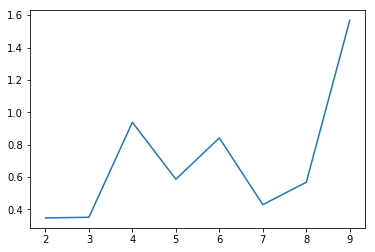

In [51]:
plt.plot(ks[1:-1], diff_r)

In [52]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

2

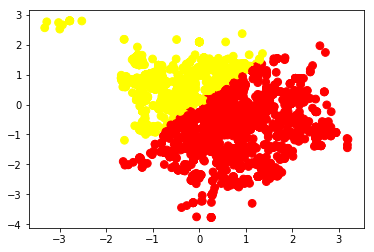

In [54]:
kmeans = KMeans(n_clusters=k_opt)
kmeans_clusters = kmeans.fit_predict(source_cleaned[['x', 'y']])
plt.scatter(source_cleaned.x, source_cleaned.y, c=kmeans_clusters, cmap='autumn', s=60)

#### Коэффициент разницы для 2, 3 и 7 кластеров практически не отличается, поэтому построю картинки и для остальных значений

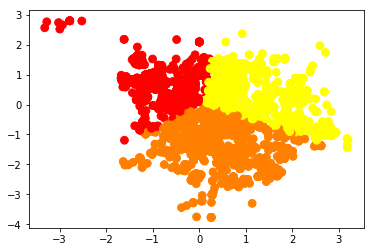

In [55]:
kmeans = KMeans(n_clusters=3)
kmeans_clusters = kmeans.fit_predict(source_cleaned[['x', 'y']])
plt.scatter(source_cleaned.x, source_cleaned.y, c=kmeans_clusters, cmap='autumn', s=60)

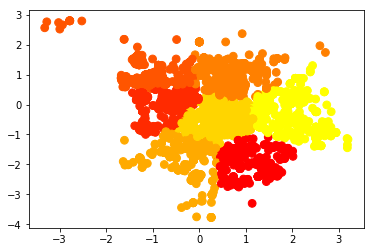

In [56]:
kmeans = KMeans(n_clusters=7)
kmeans_clusters = kmeans.fit_predict(source_cleaned[['x', 'y']])
plt.scatter(source_cleaned.x, source_cleaned.y, c=kmeans_clusters, cmap='autumn', s=60)

### Аналогично исследовать скопления голосов за и против отдельно

#### Голосование "За"

In [59]:
source_yes = source_cleaned[source_cleaned['comment_class'] == 1]

In [61]:
k_inertia_yes = []
ks = range(1,11)

for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans_clusters = kmeans.fit_predict(source_yes[['x', 'y']])
    k_inertia_yes.append(kmeans.inertia_)

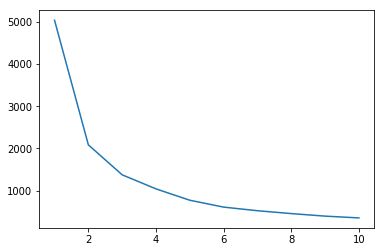

In [62]:
plt.plot(ks, k_inertia_yes)

In [63]:
diff_yes = np.diff(k_inertia_yes)

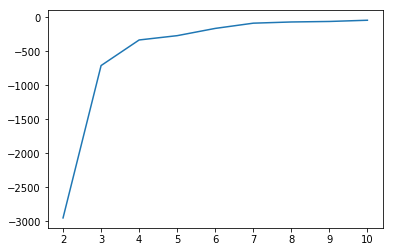

In [64]:
plt.plot(ks[1:], diff_yes)

In [65]:
diff_r_yes = diff_yes[1:] / diff_yes[:-1]

In [66]:
diff_r_yes

array([ 0.2402817 ,  0.46912421,  0.80916698,  0.60369813,  0.5260954 ,
        0.79335298,  0.88831908,  0.70278818])

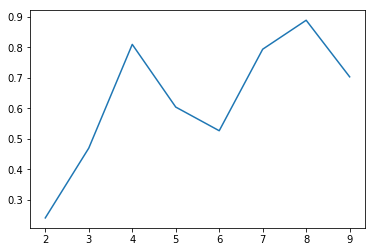

In [67]:
plt.plot(ks[1:-1], diff_r_yes)

In [68]:
k_opt_yes = ks[np.argmin(diff_r_yes)+1]
k_opt_yes

2

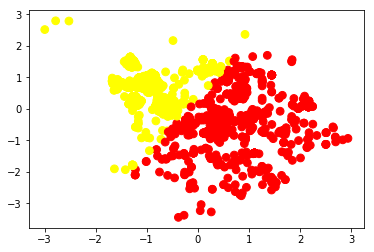

In [69]:
kmeans = KMeans(n_clusters=k_opt_yes)
kmeans_clusters = kmeans.fit_predict(source_yes[['x', 'y']])
plt.scatter(source_yes.x, source_yes.y, c=kmeans_clusters, cmap='autumn', s=60)

#### Картинка выходит скучная, попробую выделить хотя бы 3 района

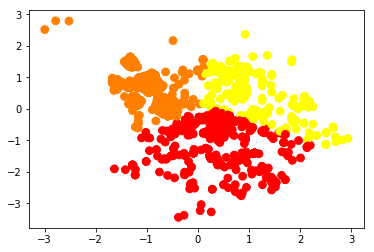

In [70]:
kmeans = KMeans(n_clusters=3)
kmeans_clusters = kmeans.fit_predict(source_yes[['x', 'y']])
plt.scatter(source_yes.x, source_yes.y, c=kmeans_clusters, cmap='autumn', s=60)

#### Голосование "Против"

In [72]:
source_no = source_cleaned[source_cleaned['comment_class'] == -1]

In [73]:
k_inertia_no = []
ks = range(1,11)

for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans_clusters = kmeans.fit_predict(source_no[['x', 'y']])
    k_inertia_no.append(kmeans.inertia_)

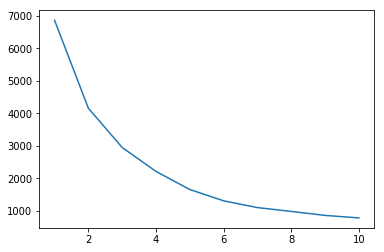

In [74]:
plt.plot(ks, k_inertia_no)

In [75]:
diff_no = np.diff(k_inertia_no)

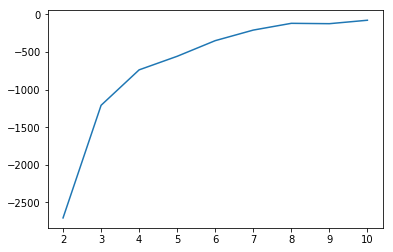

In [76]:
plt.plot(ks[1:], diff_no)

In [77]:
diff_r_no = diff_no[1:] / diff_no[:-1]

In [78]:
diff_r_no

array([ 0.4464956 ,  0.60977754,  0.75513003,  0.62621171,  0.59665476,
        0.56720959,  1.04063917,  0.62722403])

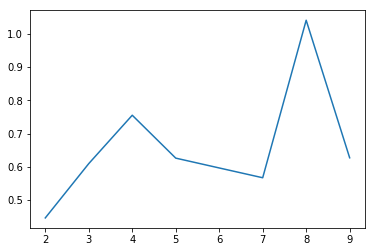

In [80]:
plt.plot(ks[1:-1], diff_r_no)

In [81]:
k_opt_no = ks[np.argmin(diff_r_no)+1]
k_opt_no

2

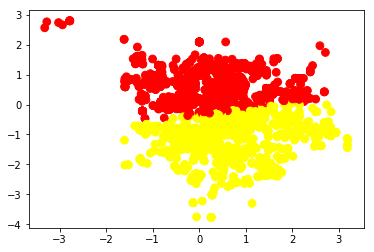

In [82]:
kmeans = KMeans(n_clusters=k_opt_no)
kmeans_clusters = kmeans.fit_predict(source_no[['x', 'y']])
plt.scatter(source_no.x, source_no.y, c=kmeans_clusters, cmap='autumn', s=60)

#### Опять скучная картинка, есть еще 1 неплохая разница при 7 кластерах. Попробую построить 7 кластеров.

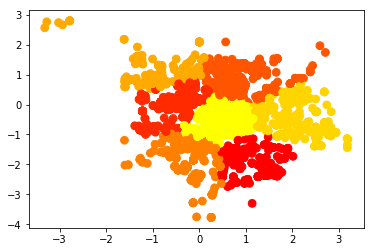

In [83]:
kmeans = KMeans(n_clusters=7)
kmeans_clusters = kmeans.fit_predict(source_no[['x', 'y']])
plt.scatter(source_no.x, source_no.y, c=kmeans_clusters, cmap='autumn', s=60)

### Найти наиболее активные в голосовании районы (подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')

In [84]:
from sklearn.cluster import DBSCAN

In [261]:
dbscan = DBSCAN(eps=0.2, min_samples=20)

In [262]:
clusters = dbscan.fit_predict(source_cleaned[['x', 'y']])

In [263]:
x = source_cleaned['x'].values
y = source_cleaned['y'].values

In [264]:
not_clustered = clusters == -1

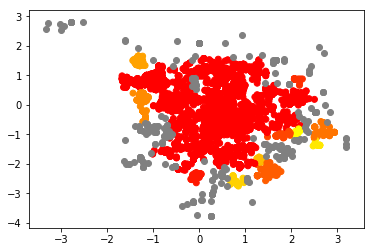

In [267]:
plt.scatter(x[~not_clustered], y[~not_clustered], c = clusters[~not_clustered], cmap = 'autumn')
plt.scatter(x[not_clustered], y[not_clustered], c = 'grey')
plt.show()